In [1]:
import os
os.getcwd()

'/Users/kwonk/Documents/Bootcamp/TEST_sentiment/LSTM'

In [2]:
import numpy as np 
import pandas as pd 
import seaborn

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(os.listdir("../LSTM/input"))

['.DS_Store', 'test.csv', 'train.csv']


In [3]:
# The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm

In [4]:
# Use Keras Tensorflow deeplearning library
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

#set random seed for the session and also for tensorflow that runs in background for keras
set_random_seed(123)
random.seed(123)

Using TensorFlow backend.


In [5]:
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from matplotlib.pylab import rcParams

from sklearn.metrics import roc_curve,auc,make_scorer, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import eli5 # for permutation importance
from eli5.sklearn import PermutationImportance

import shap # for SHAP value
from pdpbox import pdp, info_plots # flor partial plots 

np.random.seed(123)
pd.options.mode.chained_assignment = None  #hide any pandas warnings
%matplotlib inline

In [6]:
# Load Dataset
train= pd.read_csv("../LSTM/input/train.csv")
test = pd.read_csv("../LSTM/input/test.csv")

train.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
# pip install ftfy
# import ftfy
# ftfy.fix_text(train[train['tweet']])

In [8]:
train.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [9]:
# Train dataset: Need only class as "Sentiment" and text as 'Phrase'
train = train.rename(columns={'class':'Sentiment','tweet':'Phrase'})
train = train.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'],axis=1).copy()
train.head()

,Sentiment,Phrase
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [10]:
test.head()

,Text,Date,Favorites,Retweets,Tweet ID
0,Nielson Media Research final numbers on ACCEPT...,7/30/16 23:32,13850,4130,7.600000e+17
1,Thank you to all of the television viewers tha...,7/30/16 19:00,27659,6842,7.600000e+17
2,Can you imagine if I had the small crowds that...,7/30/16 18:28,19968,6488,7.600000e+17
3,NATO commander agrees members should pay up vi...,7/30/16 18:24,11624,4668,7.600000e+17
4,"Wow, NATO's top commander just announced that ...",7/30/16 18:18,23922,7819,7.600000e+17


In [11]:
test.columns

Index(['Text', 'Date', 'Favorites', 'Retweets', 'Tweet ID'], dtype='object')

In [12]:
# Test dataset: Need only text as 'Phrase'
test = test.rename(columns={'Text':'Phrase'})
test = test.drop(['Date', 'Favorites', 'Retweets', 'Tweet ID'],axis=1).copy()
test.head()

,Phrase
0,Nielson Media Research final numbers on ACCEPT...
1,Thank you to all of the television viewers tha...
2,Can you imagine if I had the small crowds that...
3,NATO commander agrees members should pay up vi...
4,"Wow, NATO's top commander just announced that ..."


In [13]:
train.shape

(24778, 2)

In [14]:
train.dtypes

Sentiment     int64
Phrase       object
dtype: object

In [15]:
test.shape

(29886, 1)

In [16]:
test.dtypes

Phrase    object
dtype: object

In [17]:
# Clean tweets, tokenize, and lemmatize
#     remove html content
#     remove non-alphabetic characters
#     tokenize the sentences
#     lemmatize each word to its lemma (the basic or stem of that word)
        # ex) playing --> play

In [18]:
# Need to Save the split texts before cleaning and tokenizing
# Collect dependent values and convert to ONE-HOT encoding
# Output using to_categorical
target_t = train.Sentiment.values
y_target_t = to_categorical(target_t)

# Save the texts before tokenizing (must use the same random seed)
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(train,y_target_t,test_size=0.2,random_state=42,stratify=y_target_t)

In [19]:
def clean_sentences(df):
    tweets = []
    
    for sent in tqdm(df['Phrase']):
        
        # remove non-alphabetic characters
        tweet_text = re.sub("[^a-zA-Z]"," ", str(sent))
        
        #remove html content
        tweet_text = BeautifulSoup(tweet_text).get_text()
        
        # tokenize
        words = word_tokenize(tweet_text.lower())
        
        # lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        tweets.append(lemma_words)
        
    return(tweets)

In [20]:
# cleaned tweets for both train and test set retrieved

train_sentences = clean_sentences(train)

100%|██████████| 24778/24778 [00:10<00:00, 2360.11it/s]


In [21]:
test_sentences = clean_sentences(test)

100%|██████████| 29886/29886 [00:11<00:00, 2522.35it/s]


In [22]:
print(len(train_sentences))
print(len(test_sentences))

24778
29886


In [23]:
train_sentences[3]

['rt',
 'c',
 'g',
 'anderson',
 'viva',
 'based',
 'she',
 'look',
 'like',
 'a',
 'tranny']

In [24]:
test_sentences[1000]

['heading',
 'to',
 'rally',
 'with',
 'bobby',
 'now',
 'see',
 'you',
 'soon',
 'pic',
 'twitter',
 'com',
 'dwssoectzn']

In [25]:
# Collect dependent values and convert to ONE-HOT encoding
# Output using to_categorical
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [26]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_sentences,y_target,test_size=0.2,random_state=42,stratify=y_target)

In [27]:
# Getting the no of unique words and max length of a tweet available in the list of cleaned tweets
# It is needed for initializing tokenizer of keras and subsequent padding

# Build an unordered collection of unique elements.
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max=len(sent)

# length of the list of unique_words gives the no of unique words

print(len(list(unique_words)))
print(len_max)


100%|██████████| 19822/19822 [00:00<00:00, 508582.42it/s]

28701
53


In [28]:
# Actual tokenizer of keras and convert to sequences

tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

# texts_to_sequences
# ARGUMENTS: list of texts to turn to sequences
# RETURN: list of sequences (one per text input)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

In [29]:
# Padding is done to equalize the lengths of all input tweets.
# LTSM networks need all inputs to be same length.
# Therefore, tweets lesser than max length will be made equal using extra zeros at end. This is padding.
# Also, you always have to give a three-dimensional array as an input to your LSTM network

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape,y_val.shape,y_train.shape)

(19822, 53) (4956, 53) (29886, 53) (4956, 3) (19822, 3)


In [30]:
# Early stopping to prevent overfitting deep learning neural network models
# This is a method that allows you to specify an arbitrary large number of training epochs.
# This stops training once the model performance stops improving on a hold out validation dataset


early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor = 'val_acc', patience = 2)
callback = [early_stopping]


In [31]:
# Model with Keras LSTM
# Multilayer Perceptron (MLP) for multi-class softmax classification
# Build NLP model called: Long Short Term Memory Network
# This model works on sequenced data
# It's good for NLP task like tagging and text classification
# It treats text as a sequence rather than a bag of words or as ngrams

In [32]:
# LSTM hyperparameters for reference

# Embedding(
#     input_dim,
#     output_dim,
#     embeddings_initializer='uniform',
#     embeddings_regularizer=None,
#     activity_regularizer=None,
#     embeddings_constraint=None,
#     mask_zero=False,
#     input_length=None,
#     **kwargs,
# )

# LSTM(
#     units,
#     activation='tanh',
#     recurrent_activation='hard_sigmoid',
#     use_bias=True,
#     kernel_initializer='glorot_uniform',
#     recurrent_initializer='orthogonal',
#     bias_initializer='zeros',
#     unit_forget_bias=True,
#     kernel_regularizer=None,
#     recurrent_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     recurrent_constraint=None,
#     bias_constraint=None,
#     dropout=0.0,
#     recurrent_dropout=0.0,
#     implementation=1,
#     return_sequences=False,
#     return_state=False,
#     go_backwards=False,
#     stateful=False,
#     unroll=False,
#     **kwargs,
# )

![lstm_network](../LSTM/figures/lstm_network.png)

In [33]:
# model = Sequential()

In [34]:
# model.add(Embedding(len(list(unique_words)),300,input_length=len_max))

In [35]:
# If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)
# Tensorflow’s num_units is the size of the LSTM’s hidden state (which is also the size of the output if 
# no projection is used). To make the name num_units more intuitive, you can think of it as the number of hidden units in the LSTM cell, 
# or the number of memory units in the cell.
# model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))

In [36]:
# if return_sequence is False, the output is a 2D array. (batch_size, units)
# model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))

In [37]:
# model.add(Dense(100,activation='relu'))

In [38]:
# model.add(Dropout(0.5))
# help reducing interdependent learning amongst the neurons by ignoring certain neurons at random at each training stage 

In [39]:
# model.add(Dense(num_classes,activation='softmax'))

In [40]:
# model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])

In [41]:
# model.summary()

In [66]:
# re-run model everytime new parameter changes (must run sequential to initialize epoch)

model = Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu')) #try elu
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 53, 300)           8610300   
_________________________________________________________________
lstm_5 (LSTM)                (None, 53, 128)           219648    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total params: 8,886,159
Trainable params: 8,886,159
Non-trainable params: 0
_________________________________________________________________


In [41]:
# elu

model = Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='elu')) #try elu
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 53, 300)           8610300   
_________________________________________________________________
lstm_3 (LSTM)                (None, 53, 128)           219648    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 8,886,159
Trainable params: 8,886,159
Non-trainable params: 0
_________________________________________________________________


In [43]:
# hyperparameter tuning
# EPOCH: One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.
# As the number of epochs increases, more number of times the weight are changed in the neural network 
# and the curve goes from underfitting to optimal to overfitting curve.

# BATCH: Total number of training examples present in a single batch. 
#you can’t pass the entire dataset into the neural net at once. 
# So, you divide dataset into Number of Batches or sets or parts.

# ITERATION: Iterations is the number of batches needed to complete one epoch.
# Ex) Our train n=19822
# With batch size of 200, there are 99 iterations for 1 epoch.

In [44]:
# Create weights: Our dataset has only 5.8% HATE, 16.8% Neither and majority 77.4% Offensive 
# To balance the classifiers, we will set Hate and Offensive weights greater than Offensive

In [42]:
# create pandas df for y_train
# Describe classifier hate (0), offensive (1), neither or neutral (2)

y_df = pd.DataFrame(y_train)
y_df.describe()

,0,1,2
count,19822.000000,19822.000000,19822.000000
mean,0.057714,0.774291,0.167995
std,0.233225,0.418088,0.373885
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [43]:
# Sum up the no. of records for each classifier
hate_num = y_df[0].sum()
offensive_num = y_df[1].sum()
neutral_num = y_df[2].sum()

In [44]:
# check hate (1144/19822 = 5.8%)
hate_num

1144.0

In [45]:
# check offensive (15348/19822 = 77.4%)
offensive_num

15348.0

In [46]:
# check neutral (3333/19822 = 16.8%)
neutral_num

3330.0

In [47]:
# Do inverse ratio so that hate and neutral has a higher weight
1 - hate_num / len(y_df)

0.9422863485016648

In [48]:
1 - neutral_num / len(y_df)

0.8320048431036222

In [49]:
# Inverse ratio will give offensive a lower weight
1 - offensive_num / len(y_df)

0.22570880839471297

In [67]:
# fit the model adjusting for epochs, batch, and weight

history = model.fit(
    X_train, y_train, 
    validation_data=(X_val,y_val),
    epochs=15, #may not run all due to callback
    batch_size=256, #faster with larger batch_size but it's generalizing
    verbose=1,
    callbacks=callback, #stops training once the model stops improving. Prevents overfitting.
    class_weight={0: .94*100, 1: .23, 2: .83*10} #use inverse ratio to set hate with highest weight (somewhat arbitrary)
) 

Train on 19822 samples, validate on 4956 samples
Epoch 1/15
19822/19822 [==============================] - 72s 4ms/step - loss: 3.9809 - acc: 0.1026 - val_loss: 3.0728 - val_acc: 0.0577
Epoch 2/15
19822/19822 [==============================] - 68s 3ms/step - loss: 2.0021 - acc: 0.1972 - val_loss: 2.5467 - val_acc: 0.2006
Epoch 3/15
19822/19822 [==============================] - 69s 3ms/step - loss: 0.9781 - acc: 0.2194 - val_loss: 2.3443 - val_acc: 0.2058
Epoch 4/15
19822/19822 [==============================] - 69s 4ms/step - loss: 0.5765 - acc: 0.3542 - val_loss: 1.7857 - val_acc: 0.3707
Epoch 5/15
19822/19822 [==============================] - 68s 3ms/step - loss: 0.4670 - acc: 0.6149 - val_loss: 1.5322 - val_acc: 0.6517
Epoch 6/15
19822/19822 [==============================] - 68s 3ms/step - loss: 0.3730 - acc: 0.7503 - val_loss: 1.0392 - val_acc: 0.7581
Epoch 7/15
19822/19822 [==============================] - 68s 3ms/step - loss: 0.2769 - acc: 0.8159 - val_loss: 1.9453 - val_acc:

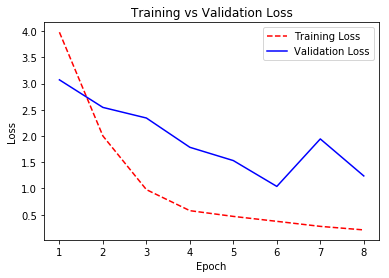

In [68]:
# Create count of the number of epochs
epoch_count = range(1,len(history.history['loss']) + 1)

# Visualize the learning curve.

plt.plot(epoch_count,history.history['loss'],'r--')
plt.plot(epoch_count,history.history['val_loss'],'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

# save figure
plt.savefig('../LSTM/figures/loss.png')

plt.show()

In [55]:
# Loss: A scalar value that we attempt to minimize during our training of the model. 
# The lower the loss, the closer our predictions are to the true labels.
# The lower the loss, the better a model (unless the model has over-fitted to the training data). 
# The loss is calculated on training and validation and its interperation is how well the model is doing for 
# these two sets. Unlike accuracy, loss is not a percentage. 
# It is a summation of the errors made for each example in training or validation sets.

In [69]:
# Predict validation sentiment!

y_pred = model.predict(X_val)

In [70]:
# Keras doesn't have f1 score in metrics - therefore we have to manually calculate
from keras import backend as K

def recall_m(y_val, y_pred):
        true_positives = K.sum(K.round(K.clip(y_val * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_val, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_val, y_pred):
        true_positives = K.sum(K.round(K.clip(y_val * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_val, y_pred):
    precision = precision_m(y_val, y_pred)
    recall = recall_m(y_val, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [71]:
# Compile with more metrics to evaluate model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

In [72]:
# Evaluate model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_val,y_val,verbose=1)

4956/4956 [==============================] - 13s 3ms/step


In [73]:
print(f"loss {loss}")
print(f"accuracy {accuracy}")
print(f"f1 score {f1_score}")
print(f"precision {precision}")
print(f"recall {recall}")

loss 1.239153745965288
accuracy 0.7471751412910449
f1 score 0.7467583217767095
precision 0.750542137341888
recall 0.7431396287809562


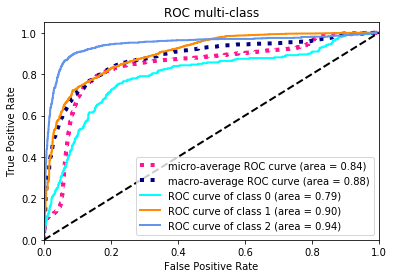

In [74]:
# Use trained Keras model to predict test inputs and generate ROC data
# Plot ROC for each of the 3 classes


import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# 3 classes to classify
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC multi-class')
plt.legend(loc="lower right")

# Save figure
plt.savefig('../LSTM/figures/roc.png')

plt.show()



In [75]:
# Keras and Sklearn read arrays differently
# Create function to convert keras array to show only one highest sentiment result per list
def keras_output_sklearn(y):
    
    result = []
    
    for element in y:
        result.append(np.argmax(element))
        

    return result

In [76]:
# use sklearn's confusion matrix to view correlation between truth and prediction
# use keras_output_sklearn function to reshape
confusion_matrix_t = confusion_matrix(keras_output_sklearn(y_val),keras_output_sklearn(y_pred))
# counts in each cell
confusion_matrix_t

array([[ 188,   58,   40],
       [ 721, 2762,  355],
       [  34,   45,  753]])

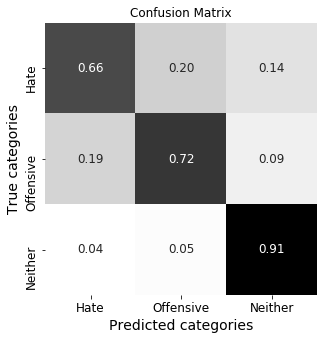

In [77]:
# Use seaborn to see counts in percentages
# Truth categories yield 100%
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix_t[i,:]/float(confusion_matrix_t[i,:].sum())
names=['Hate','Offensive','Neither']
# save result as pandas df
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.title('Confusion Matrix')
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
plt.savefig('../LSTM/figures/confusion.png')


In [62]:
# Create joblib file
# from joblib import dump, load
# dump(model,'lstm.joblib')

## Save MODEL

In [78]:
from keras.models import load_model

model.save('lstm_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('lstm_model.h5',compile=False)

In [79]:
# save as JSON
json_string = model.to_json()

# save as YAML
yaml_string = model.to_yaml()

In [80]:
# to load it again
# model reconstruction from JSON:
from keras.models import model_from_json
model = model_from_json(json_string)

# model reconstruction from YAML:
from keras.models import model_from_yaml
model = model_from_yaml(yaml_string)

## Predict on test tweets

In [341]:
test = pd.read_csv("../LSTM/input/test.csv")
test = test.rename(columns={'Text':'Phrase'})
test = test.drop(['Date', 'Favorites', 'Retweets', 'Tweet ID'],axis=1).copy()
unique_words = 28701
len_max = 53
tokenizer = Tokenizer(unique_words)
tokenizer.fit_on_texts(list(test_sentences))
X_test = tokenizer.texts_to_sequences(test_sentences)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
from keras.models import load_model
model = load_model('lstm_model.h5',compile=False)
# save as JSON
json_string = model.to_json()

# save as YAML
yaml_string = model.to_yaml()

# model reconstruction from JSON:
from keras.models import model_from_json
model = model_from_json(json_string)

# model reconstruction from YAML:
from keras.models import model_from_yaml
model = model_from_yaml(yaml_string)

In [342]:
# RUN MODEL on TEST DATA!
predicted_output = model.predict(X_test, batch_size=256)

In [343]:
# create pandas df with predictions 
df_test_predict = pd.DataFrame(keras_output_sklearn(predicted_output))

In [344]:
df_test_predict.head()

,0
0,2
1,0
2,1
3,2
4,0


In [345]:
df_test_predict.columns

RangeIndex(start=0, stop=1, step=1)

In [346]:
#rename column
df_test_predict.rename(columns={df_test_predict.columns[0]: "result" }, inplace = True)
df_test_predict.head(10)

,result
0,2
1,0
2,1
3,2
4,0
5,0
6,1
7,2
8,0
9,2


In [347]:
# replace sentiment values
df_test_predict = df_test_predict.replace({0:'hate',1:'offensive',2:'neutral'})
df_test_predict.head(10)

,result
0,neutral
1,hate
2,offensive
3,neutral
4,hate
5,hate
6,offensive
7,neutral
8,hate
9,neutral


In [348]:
df_test_predict['result'].value_counts()

hate         16447
neutral       8075
offensive     5364
Name: result, dtype: int64

In [349]:
# normalize to percentages
norm = pd.DataFrame(df_test_predict['result'].value_counts(normalize=True)*100)
norm

,result
hate,55.032457
neutral,27.019340
offensive,17.948203


In [309]:
# print results
print(f"hate prediction: {norm.loc['hate','result']}")
print(f"offensive prediction: {norm.loc['offensive','result']}")
print(f"neutral prediction: {norm.loc['neutral','result']}")

hate prediction: 15.194405407214079
offensive prediction: 79.16081108211202
neutral prediction: 5.644783510673894


In [ ]:
# 

In [314]:
# trump tweets 
test.head()

,Phrase
0,Nielson Media Research final numbers on ACCEPT...
1,Thank you to all of the television viewers tha...
2,Can you imagine if I had the small crowds that...
3,NATO commander agrees members should pay up vi...
4,"Wow, NATO's top commander just announced that ..."


In [315]:
# merge prediction and trump tweets
df_test_compare = pd.merge(test,df_test_predict,left_index=True,right_index=True)

In [318]:
df_test_compare.head(10)

,Phrase,result
0,Nielson Media Research final numbers on ACCEPT...,offensive
1,Thank you to all of the television viewers tha...,offensive
2,Can you imagine if I had the small crowds that...,offensive
3,NATO commander agrees members should pay up vi...,offensive
4,"Wow, NATO's top commander just announced that ...",offensive
5,"The ""Rust Belt"" was created by politicians lik...",offensive
6,"Crooked's stop in Johnstown, Pennsylvania, whe...",offensive
7,"#CrookedHillary = Obama's third term, which wo...",offensive
8,Word is that Crooked Hillary has very small an...,hate
9,I turned down a meeting with Charles and David...,offensive


In [319]:
# output to csv
df_test_compare.to_csv("../LSTM/trump_prediction.csv")

## Compare tweets from validation set prediction vs truth

In [265]:
keras_output_sklearn(y_pred[3166:3168])

[0, 0]

In [266]:
keras_output_sklearn(y_val[3166:3168])

[1, 1]

In [267]:
X_val[5]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 8469,  205,    2,    1,
         15,   20,   50,   18,    7,   44,  102,    5, 8244], dtype=int32)

In [268]:
X_val[5]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 8469,  205,    2,    1,
         15,   20,   50,   18,    7,   44,  102,    5, 8244], dtype=int32)

In [269]:
# create pandas df 
df_predict = pd.DataFrame(keras_output_sklearn(y_pred))

In [270]:
df_predict.head()

,0
0,2
1,1
2,1
3,1
4,0


In [271]:
df_truth = pd.DataFrame(keras_output_sklearn(y_val))
df_truth.head()

,0
0,2
1,1
2,1
3,1
4,1


In [272]:
# merge predict and merge
df_compare = pd.merge(df_predict,df_truth,left_index=True,right_index=True,
                      suffixes=('_predict', '_truth'))


In [273]:
df_compare.head()

,0_predict,0_truth
0,2,2
1,1,1
2,1,1
3,1,1
4,0,1


In [274]:
# Non-tokenized splits X_train_t, X_val_t, y_train_t, y_val_t 
X_val_t.head()

,Sentiment,Phrase
3166,2,@FightNightX @NMF4Life khan has been facing no...
22896,1,Why the most Ratchet bitches be talkin shit? Y...
19022,1,RT @fvckzaina: The only D yah bitches should b...
19429,1,RT @khulekile_32220: The karma of fucking over...
8547,1,Cruising in my go kart at walmart selling cupc...


In [275]:
# reset index on X_val_t
X_val_df = X_val_t.reset_index()
X_val_df.head(10)

,index,Sentiment,Phrase
0,3166,2,@FightNightX @NMF4Life khan has been facing no...
1,22896,1,Why the most Ratchet bitches be talkin shit? Y...
2,19022,1,RT @fvckzaina: The only D yah bitches should b...
3,19429,1,RT @khulekile_32220: The karma of fucking over...
4,8547,1,Cruising in my go kart at walmart selling cupc...
5,6811,0,@passIt2Liv Hit a bitch it's not like you can ...
6,21016,1,Some bitches curve game be too serious
7,18242,1,RT @_BeautifulKeezy: &#8220;@100046729: Small ...
8,3411,1,@Hunglikerobby_ @triple6em96 @bbluedreamm brus...
9,21475,0,The #midwest of the US is white trash.


In [276]:
# merge actual tweet
df_compare_text = pd.merge(df_compare,X_val_df,left_index=True,right_index=True)

In [277]:
df_compare_text.head()

,0_predict,0_truth,index,Sentiment,Phrase
0,2,2,3166,2,@FightNightX @NMF4Life khan has been facing no...
1,1,1,22896,1,Why the most Ratchet bitches be talkin shit? Y...
2,1,1,19022,1,RT @fvckzaina: The only D yah bitches should b...
3,1,1,19429,1,RT @khulekile_32220: The karma of fucking over...
4,0,1,8547,1,Cruising in my go kart at walmart selling cupc...


In [278]:
df_compare_sentiment = df_compare_text[df_compare_text['0_predict']!=df_compare_text['0_truth']]

In [279]:
df_compare_sentiment.head()

,0_predict,0_truth,index,Sentiment,Phrase
4,0,1,8547,1,Cruising in my go kart at walmart selling cupc...
5,1,0,6811,0,@passIt2Liv Hit a bitch it's not like you can ...
20,2,1,589,1,Work - @tydollasign Gets me through those roug...
21,0,1,4291,1,@NotoriousBM95 @Buckm00se fucking stupid crackers
28,0,1,24773,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...


In [280]:
df_compare_sentiment = df_compare_sentiment.rename(columns={
    '0_predict':'Prediction',
    'Sentiment':'Truth'
}).drop(['0_truth','index'],axis=1).copy()
df_compare_sentiment.head()

,Prediction,Truth,Phrase
4,0,1,Cruising in my go kart at walmart selling cupc...
5,1,0,@passIt2Liv Hit a bitch it's not like you can ...
20,2,1,Work - @tydollasign Gets me through those roug...
21,0,1,@NotoriousBM95 @Buckm00se fucking stupid crackers
28,0,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...


In [281]:
len(df_compare_sentiment)

1330

In [282]:
# csv output
df_compare_sentiment.to_csv('../LSTM/wrong_prediction.csv')